In [1]:
import pandas as pd
from joblib import Memory
from datetime import datetime
from matplotlib import pyplot as plt
memory = Memory(f"cachedir/{datetime.today().date()}", compress=True)

@memory.cache
def cached_read(url):
    return pd.read_csv(url)

In [2]:
df = cached_read(
    "https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz"
)
df2 = cached_read(
    "https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz"
)
df = df.merge(df2, on="IMS_ID")
df.head(5)


________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-806506058.cached_read...
cached_read('https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz')


/tmp/ipykernel_283/806506058.py:9: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(url)


_____________________________________________________cached_read - 20.8s, 0.3min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-806506058.cached_read...
cached_read('https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz')
_____________________________________________________cached_read - 10.2s, 0.2min


,IMS_ID,DATE_DRAW,SEQ_TYPE,SEQ_REASON,SAMPLE_TYPE,OWN_FASTA_ID,RECEIVE_DATE,PROCESSING_DATE,SENDING_LAB_PC,SEQUENCING_LAB_PC,...,scorpio_conflict,scorpio_notes,version,pangolin_version,scorpio_version,constellation_version,is_designated,qc_status,qc_notes,note
0,IMS-10294-CVDP-00001,2021-01-14,ILLUMINA,X,S002,NaN,2021-01-25,2021-01-25,40225.0,40225.0,...,NaN,NaN,PUSHER-v1.8,4.0.6,0.3.17,v0.1.10,False,pass,Ambiguous_content:0.02,Usher placements: B.1.1.297(1/1)
1,IMS-10025-CVDP-00001,2021-01-17,ION_TORRENT,N,S002,NaN,2021-01-26,2021-01-26,10409.0,10409.0,...,NaN,NaN,PUSHER-v1.8,4.0.6,0.3.17,v0.1.10,False,pass,Ambiguous_content:0.02,Usher placements: B.1.389(1/1)
2,IMS-10025-CVDP-00002,2021-01-17,ION_TORRENT,N,S002,NaN,2021-01-26,2021-01-26,10409.0,10409.0,...,NaN,NaN,PUSHER-v1.8,4.0.6,0.3.17,v0.1.10,False,pass,Ambiguous_content:0.02,Usher placements: B.1(1/1)
3,IMS-10025-CVDP-00003,2021-01-17,ION_TORRENT,N,S002,NaN,2021-01-26,2021-01-26,10409.0,10409.0,...,NaN,NaN,PUSHER-v1.8,4.0.6,0.3.17,v0.1.10,False,pass,Ambiguous_content:0.02,Usher placements: B.1.177.86(1/1)
4,IMS-10025-CVDP-00004,2021-01-17,ION_TORRENT,N,S002,NaN,2021-01-26,2021-01-26,10409.0,10409.0,...,NaN,NaN,PUSHER-v1.8,4.0.6,0.3.17,v0.1.10,False,pass,Ambiguous_content:0.02,Usher placements: B.1.389(1/1)


In [3]:
var = df.copy()
var["num"] = 1
var["scorpio_call"] = (
    var["scorpio_call"]
    .str.replace(
        r"([\w ]+)? \((BA\.\d).*", r"\2", regex=True
    )  # extract BA.1 from "Omicron (BA.1-like)"
    .str.replace(r"(?:\w+ )?(\w+) \(.+", r"\1", regex=True)  # Alpha (B1.1.7)
)
var_pivot = var[
    (var["SENDING_LAB_PC"] >= 1067)
    & (var["SENDING_LAB_PC"] <= 1465)
    & (var["scorpio_call"].notna())
    & (~var.SEQ_REASON.isin(("X", "N")))
].filter(("DATE_DRAW", "scorpio_call", "num"))
var_pivot = var_pivot.groupby(["DATE_DRAW", "scorpio_call"]).sum()
var_pivot = var_pivot.reset_index().pivot(
    index="DATE_DRAW", columns="scorpio_call", values="num"
)
var_pivot.index = pd.to_datetime(var_pivot.index)
var_pivot = (
    var_pivot.rolling(3, min_periods=1, center=True, closed="both")
    .mean()
    .dropna(how="all", axis=1)
    .interpolate(method="quadratic")
    .apply(lambda x: x / x.sum(), axis=1)
    .rolling(14, min_periods=1, center=True, closed="both", win_type="cosine")
    .mean()
)
var_pivot = var_pivot.fillna(0)
# filter neglectables
var_pivot = var_pivot.loc[:, (var_pivot > 0.1).any(axis=0)]
# normalize
var_pivot["total"] = var_pivot.sum(axis=1)
var_pivot = var_pivot.divide(var_pivot["total"], axis=0)
var_pivot.drop(columns="total", inplace=True)
# omicron sum
var_pivot["Omicron"] = var_pivot["BA.1"] + var_pivot["BA.2"]
var_pivot


scorpio_call,Alpha,BA.1,BA.2,Delta,Omicron
DATE_DRAW,,,,,
2021-02-02,1.0,0.000000,0.000000,0.000000,0.000000
2021-02-08,1.0,0.000000,0.000000,0.000000,0.000000
2021-02-11,1.0,0.000000,0.000000,0.000000,0.000000
2021-02-12,1.0,0.000000,0.000000,0.000000,0.000000
2021-02-15,1.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2022-03-28,0.0,0.310427,0.614350,0.025435,0.924777
2022-04-04,0.0,0.263343,0.670150,0.021936,0.933492
2022-04-11,0.0,0.223503,0.718361,0.019174,0.941864


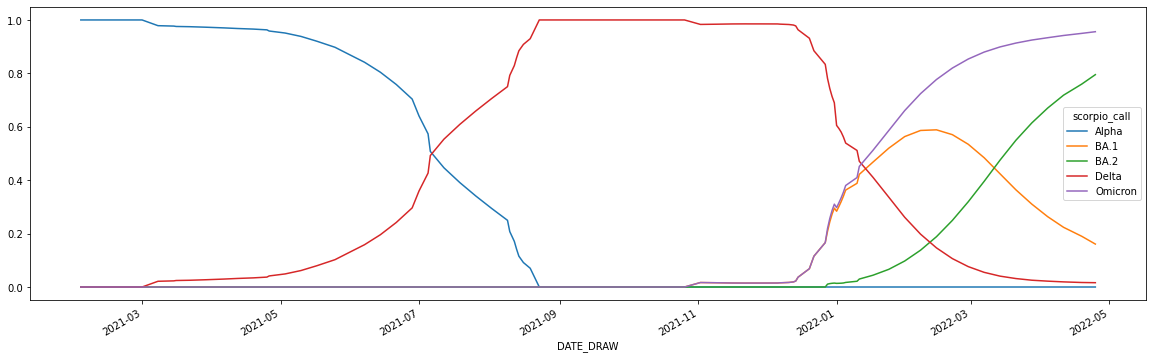

In [4]:
# plot
var_pivot.plot(figsize=(20,6))
plt.savefig("varianten.png")
plt.show()


In [5]:
var_pivot.to_csv("Dresden_Varianten.csv")
